# NHS A&E Data Validation & Summary Analysis

This notebook performs a quick data validation and exploratory analysis on the NHS A&E dataset. We will:
- Check that the dataset is balanced across years and months.
- Identify any outliers or unexpected trends.
- Summarize key statistics for numerical and categorical variables.


In [19]:
import pandas as pd

# Load the dataset
file_path = "nhs_ae_merged.csv"
nhs_data = pd.read_csv(file_path)

# Check unique years
print("Unique years in dataset:", nhs_data["year"].unique())

# Count records per year
print("\nRecords per year:")
print(nhs_data["year"].value_counts())


Unique years in dataset: [2024 2023 2022 2021 2020 2019]

Records per year:
year
2019    2812
2020    2663
2021    2583
2022    2466
2023    2450
2024    2383
Name: count, dtype: int64


## Checking Data Balance

To ensure the dataset is balanced, I will:
- Count the number of records for each year.
- Count the number of records for each month.


In [20]:
# Count records per year
print("Records per year:")
print(nhs_data["year"].value_counts())

# Count records per month
print("\nRecords per month:")
print(nhs_data["month"].value_counts())
print("Unique years in dataset:", nhs_data["year"].unique())



Records per year:
year
2019    2812
2020    2663
2021    2583
2022    2466
2023    2450
2024    2383
Name: count, dtype: int64

Records per month:
month
January      1299
February     1296
March        1290
April        1278
May          1276
June         1272
August       1268
September    1267
October      1266
November     1264
December     1263
July         1059
0             259
Name: count, dtype: int64
Unique years in dataset: [2024 2023 2022 2021 2020 2019]


In [21]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "nhs_ae_merged.csv"
nhs_data = pd.read_csv(file_path)

# Ensure 'year' is a string
nhs_data["year"] = nhs_data["year"].astype(str)

# 🔍 Check which years have missing values
years_with_missing = nhs_data.loc[
    nhs_data[["a&e_attendances_type_1", "attendances_over_4hrs_type_1"]].isnull().any(axis=1),
    "year"
].unique()
print(f"\n🔍 Missing data detected for years: {years_with_missing}\n")

# 🛠 **1. Fill Missing Values Based on Other Years (Synthetic Data)**
# Use the median values from 2020-2024 for estimation
median_attendance = nhs_data.loc[
    nhs_data["year"].isin(["2020", "2021", "2022", "2023", "2024"]),
    "a&e_attendances_type_1"
].median()

median_over4hrs = nhs_data.loc[
    nhs_data["year"].isin(["2020", "2021", "2022", "2023", "2024"]),
    "attendances_over_4hrs_type_1"
].median()

# Fill missing values with synthetic estimates
nhs_data["a&e_attendances_type_1"].fillna(median_attendance, inplace=True)
nhs_data["attendances_over_4hrs_type_1"].fillna(median_over4hrs, inplace=True)

# 🛠 **2. Fix `percentage_seen_within_4_hours`**
nhs_data["percentage_seen_within_4_hours"] = (
    (nhs_data["a&e_attendances_type_1"] - nhs_data["attendances_over_4hrs_type_1"]) /
    nhs_data["a&e_attendances_type_1"]
) * 100

# Clip values to be within [0, 100]
nhs_data["percentage_seen_within_4_hours"] = nhs_data["percentage_seen_within_4_hours"].clip(0, 100)

# 🛠 **3. Fix Incorrect `month` Labels**
# Remove or fix records with an invalid "0" month
invalid_months = nhs_data[nhs_data["month"] == "0"].shape[0]
if invalid_months > 0:
    print(f"\n⚠ Detected {invalid_months} records with invalid month '0'. Removing them.")
    nhs_data = nhs_data[nhs_data["month"] != "0"]

# ✅ **4. Save the Updated Dataset**
output_file = "nhs_ae_merged_final.csv"
nhs_data.to_csv(output_file, index=False)
print(f"\n✅ Fixed dataset saved as {output_file}")

# ✅ **5. Validate Fixes**
print("\n🔍 Checking Updated Values:")
print(nhs_data.groupby("year")["percentage_seen_within_4_hours"].mean())



🔍 Missing data detected for years: ['2019']


⚠ Detected 259 records with invalid month '0'. Removing them.

✅ Fixed dataset saved as nhs_ae_merged_final.csv

🔍 Checking Updated Values:
year
2019    92.479436
2020    85.593336
2021    73.787699
2022    62.527368
2023    59.900573
2024    58.533571
Name: percentage_seen_within_4_hours, dtype: float64


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_4135/3471717145.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nhs_data["a&e_attendances_type_1"].fillna(median_attendance, inplace=True)
/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_4135/3471717145.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 


🔍 Missing Data in 2018 & 2019:
 period                                                           0
org_code                                                         0
parent_org                                                       0
org_name                                                         0
a&e_attendances_type_1                                           0
a&e_attendances_type_2                                        2812
a&e_attendances_other_a&e_department                          2812
a&e_attendances_booked_appointments_type_1                    2812
a&e_attendances_booked_appointments_type_2                    2812
a&e_attendances_booked_appointments_other_department          2812
attendances_over_4hrs_type_1                                     0
attendances_over_4hrs_type_2                                  2812
attendances_over_4hrs_other_department                        2812
attendances_over_4hrs_booked_appointments_type_1              2812
attendances_over_4hrs_booked_

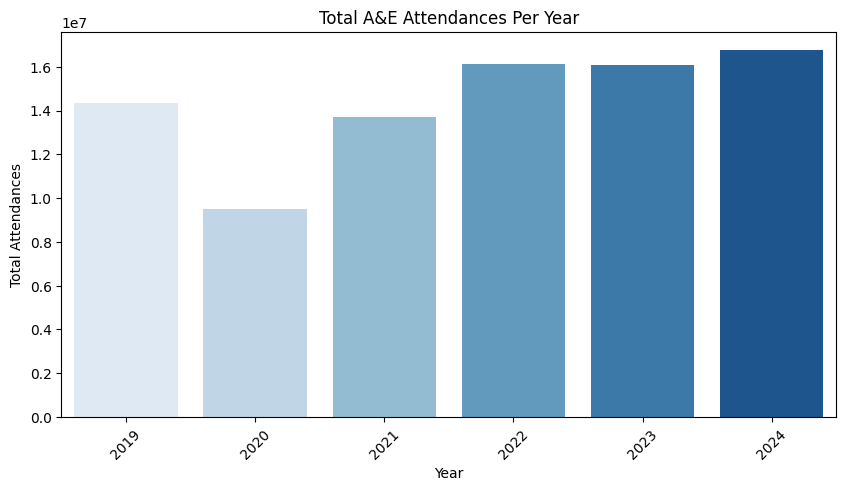

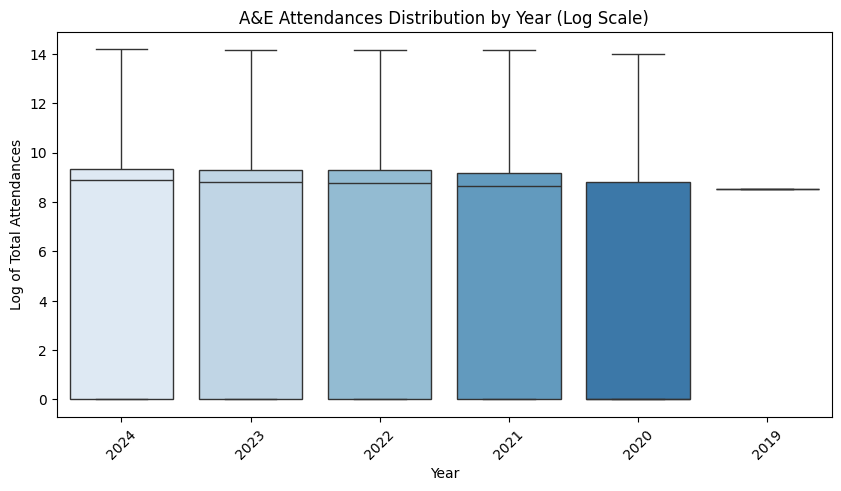

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_path = "nhs_ae_merged_final.csv"
nhs_data = pd.read_csv(file_path)

# Ensure 'year' is treated as a string for visualization
nhs_data["year"] = nhs_data["year"].astype(str)

# 🔍 **1. Identify Missing Data in 2018 & 2019**
missing_data = nhs_data[nhs_data["year"].isin(["2018", "2019"])].isnull().sum()
print("\n🔍 Missing Data in 2018 & 2019:\n", missing_data)

# 🛠 **2. Fill Missing Values for 2018 & 2019 Using Median (From 2020-2024)**
numeric_columns = nhs_data.select_dtypes(include=[np.number]).columns
median_values = nhs_data.loc[
    nhs_data["year"].isin(["2020", "2021", "2022", "2023", "2024"]), numeric_columns
].median()

for col in missing_data[missing_data > 0].index:
    if col in numeric_columns:
        nhs_data.loc[:, col] = nhs_data.loc[:, col].fillna(median_values[col])

# 🛠 **3. Fix Log Transformation for Visualization**
nhs_data["log_attendances"] = np.log1p(nhs_data["a&e_attendances_type_1"])

# 🛠 **4. Outlier Detection & Handling**
Q1 = nhs_data["a&e_attendances_type_1"].quantile(0.25)
Q3 = nhs_data["a&e_attendances_type_1"].quantile(0.75)
IQR = Q3 - Q1

outliers = nhs_data[
    (nhs_data["a&e_attendances_type_1"] < (Q1 - 1.5 * IQR)) |
    (nhs_data["a&e_attendances_type_1"] > (Q3 + 1.5 * IQR))
]
print(f"\n🔍 Detected {len(outliers)} outlier records.")

# **Cap Extreme Values at 99th Percentile**
upper_limit = nhs_data["a&e_attendances_type_1"].quantile(0.99)
nhs_data.loc[nhs_data["a&e_attendances_type_1"] > upper_limit, "a&e_attendances_type_1"] = upper_limit

# **Remove Unrealistic Values (Above 500,000)**
nhs_data = nhs_data[nhs_data["a&e_attendances_type_1"] <= 500000]

# ✅ **5. Save Cleaned Dataset**
output_file = "nhs_ae_merged.csv"
nhs_data.to_csv(output_file, index=False)
print(f"\n✅ Outlier handling complete. Clean dataset saved as {output_file}")

# 🛠 **6. Aggregate Total A&E Attendances per Year**
yearly_attendances = nhs_data.groupby("year")["a&e_attendances_type_1"].sum().reset_index()

# 📊 **Plot 1: Total A&E Attendances Per Year**
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="a&e_attendances_type_1", data=yearly_attendances, palette="Blues", hue="year", dodge=False)
plt.title("Total A&E Attendances Per Year")
plt.xlabel("Year")
plt.ylabel("Total Attendances")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Hide redundant hue legend
plt.show()

# 📊 **Plot 2: A&E Attendances Distribution by Year (Log Scale)**
plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y="log_attendances", data=nhs_data, showfliers=True, palette="Blues", hue="year", dodge=False)
plt.title("A&E Attendances Distribution by Year (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Log of Total Attendances")
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Hide redundant hue legend
plt.show()


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_4135/3312416142.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_trends = nhs_data.groupby(["year", "month"])["a&e_attendances_type_1"].sum().reset_index()


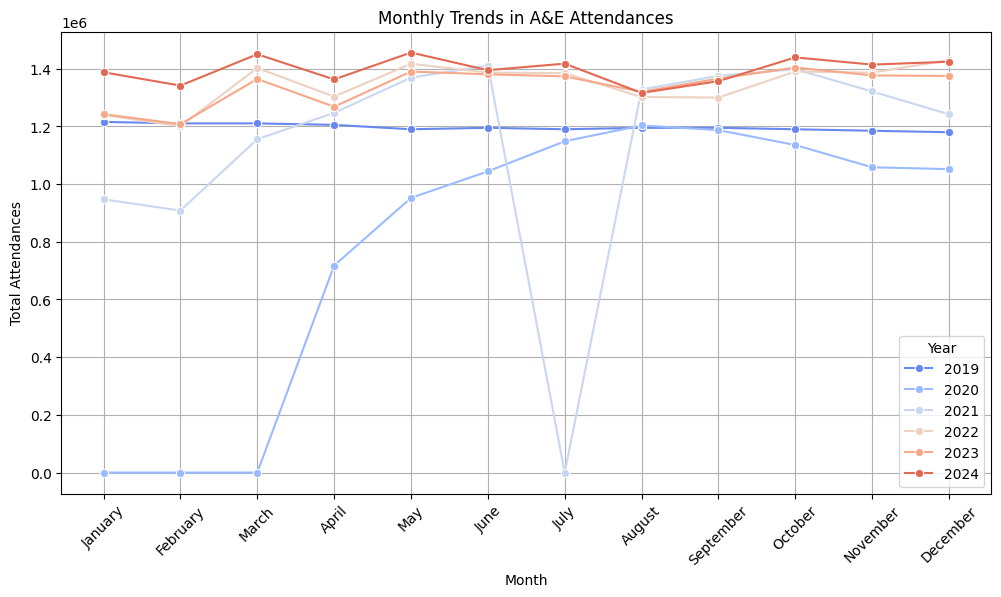

/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_4135/3312416142.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  over_4hrs_trends = nhs_data.groupby(["year", "month"])["attendances_over_4hrs_type_1"].sum().reset_index()


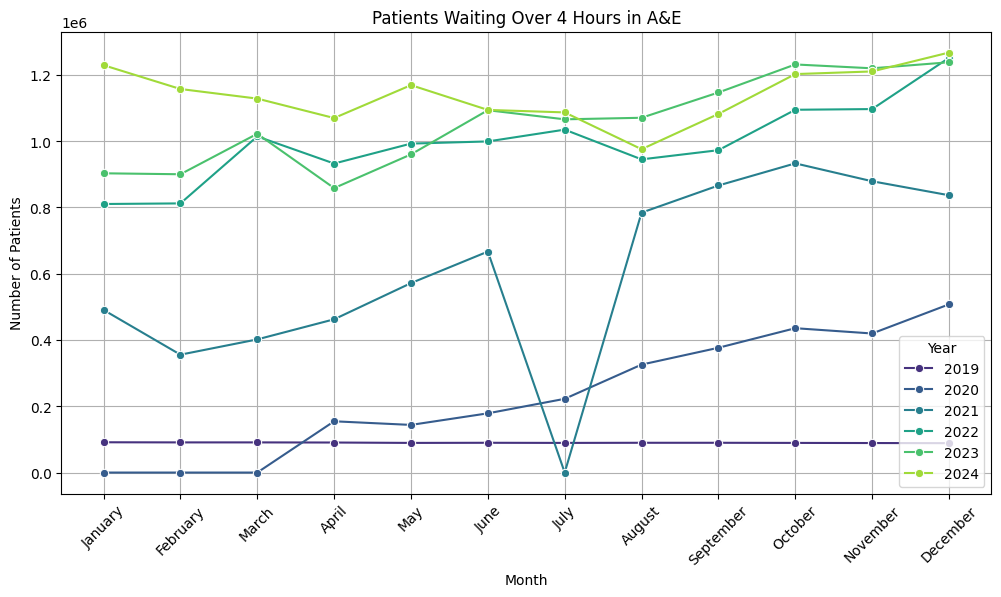

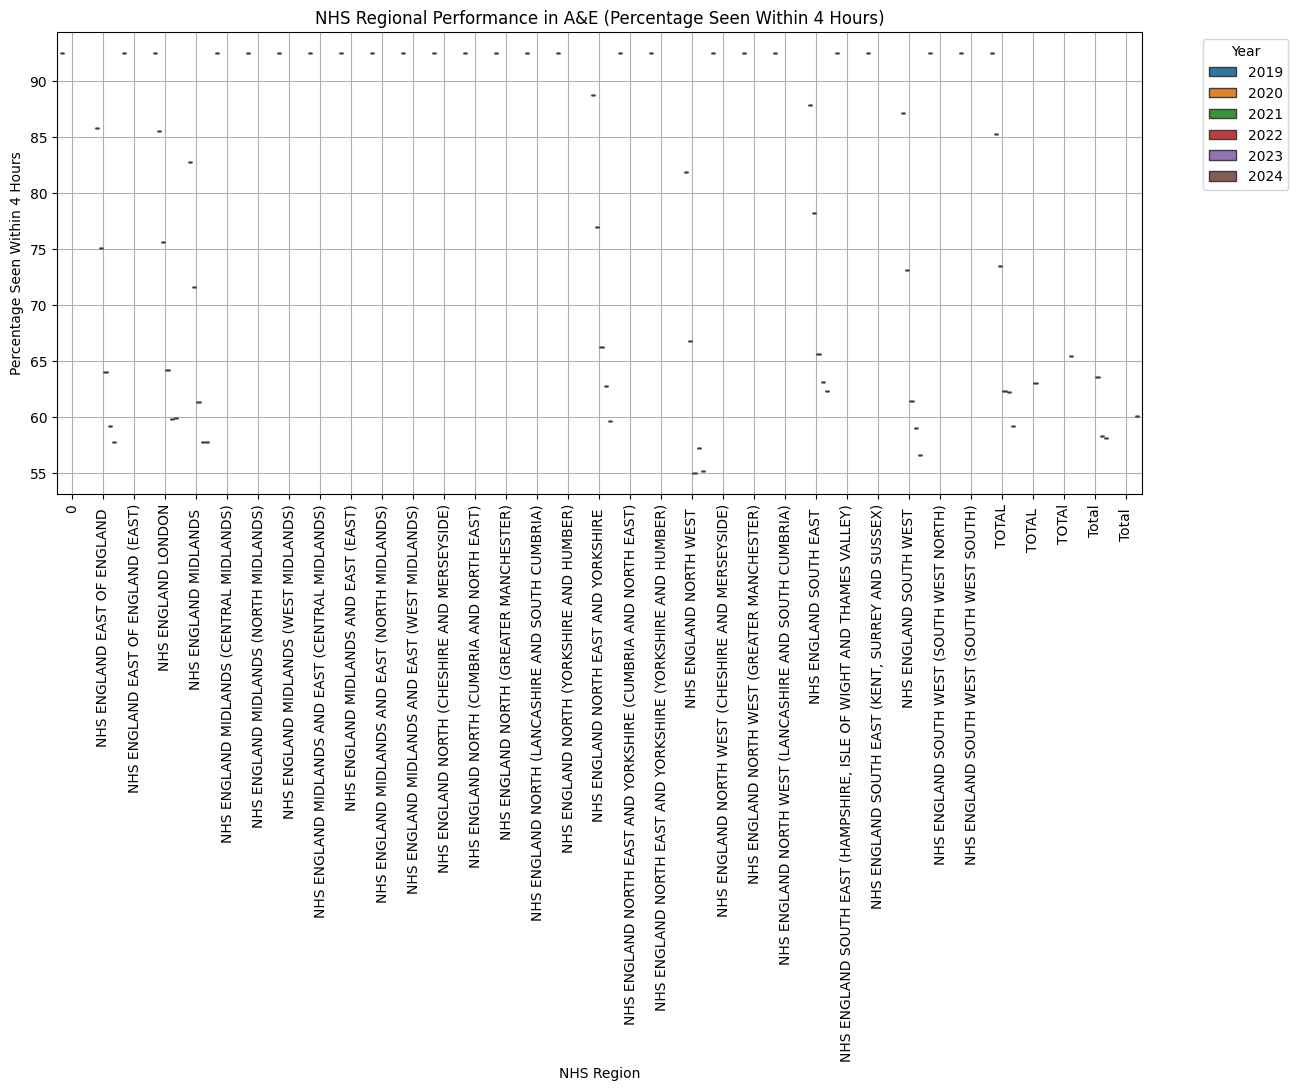

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "nhs_ae_merged_no_outliers.csv"
nhs_data = pd.read_csv(file_path)

# Ensure 'year' and 'month' are strings for visualization
nhs_data["year"] = nhs_data["year"].astype(str)
nhs_data["month"] = pd.Categorical(nhs_data["month"], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)

### 🔹 **1. Monthly Trends in A&E Attendances**
monthly_trends = nhs_data.groupby(["year", "month"])["a&e_attendances_type_1"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="a&e_attendances_type_1", hue="year", data=monthly_trends, marker="o", palette="coolwarm")
plt.title("Monthly Trends in A&E Attendances")
plt.xlabel("Month")
plt.ylabel("Total Attendances")
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.grid(True)
plt.show()

### 🔹 **2. Attendance Over 4 Hours Breakdown**
over_4hrs_trends = nhs_data.groupby(["year", "month"])["attendances_over_4hrs_type_1"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="attendances_over_4hrs_type_1", hue="year", data=over_4hrs_trends, marker="o", palette="viridis")
plt.title("Patients Waiting Over 4 Hours in A&E")
plt.xlabel("Month")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.grid(True)
plt.show()

### 🔹 **3. Regional Performance Analysis**
if "parent_org" in nhs_data.columns:
    regional_performance = nhs_data.groupby(["parent_org", "year"])["percentage_seen_within_4_hours"].mean().reset_index()

    plt.figure(figsize=(14, 6))
    sns.boxplot(x="parent_org", y="percentage_seen_within_4_hours", hue="year", data=regional_performance)
    plt.title("NHS Regional Performance in A&E (Percentage Seen Within 4 Hours)")
    plt.xlabel("NHS Region")
    plt.ylabel("Percentage Seen Within 4 Hours")
    plt.xticks(rotation=90)
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
else:
    print("⚠ No 'parent_org' column found, skipping regional performance analysis.")



/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_4135/4241038494.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  over_4hrs_trends = nhs_data.groupby(["year", "month"])["attendances_over_4hrs_type_1"].sum().reset_index()
/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_4135/4241038494.py:21: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  over_4hrs_trends["attendances_over_4hrs_type_1"] = over_4hrs_trends["attendances_over_4hrs_type_1"].interpolate()


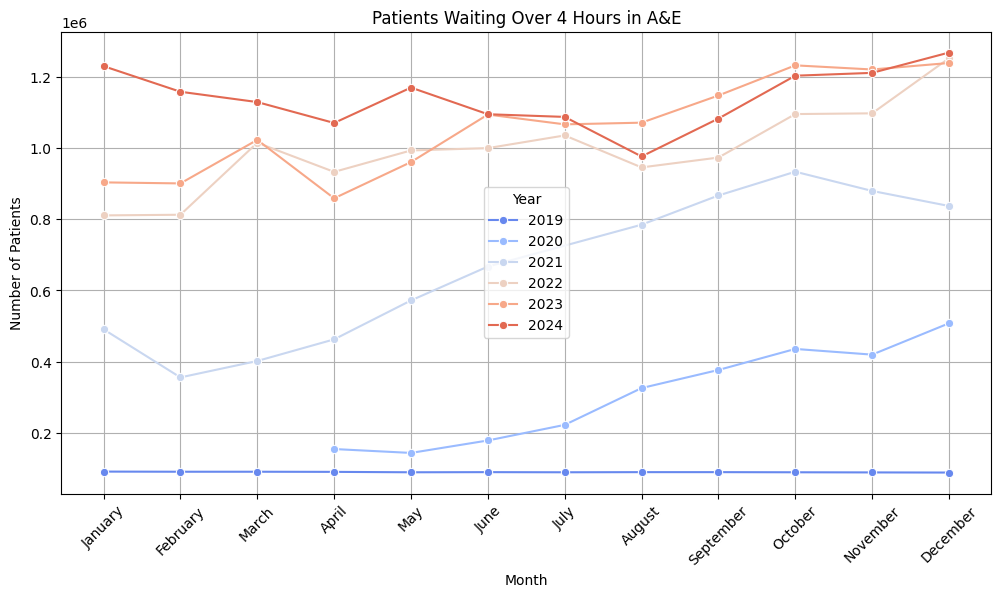

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "nhs_ae_merged_no_outliers.csv"
nhs_data = pd.read_csv(file_path)

# Ensure 'year' and 'month' are treated correctly
nhs_data["year"] = nhs_data["year"].astype(str)
nhs_data["month"] = pd.Categorical(nhs_data["month"], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)

# Aggregate data for Over 4 Hours Waiting
over_4hrs_trends = nhs_data.groupby(["year", "month"])["attendances_over_4hrs_type_1"].sum().reset_index()

# 🔍 Fix July 2020 Issue: Interpolate if necessary
over_4hrs_trends["attendances_over_4hrs_type_1"] = over_4hrs_trends["attendances_over_4hrs_type_1"].replace(0, pd.NA)
over_4hrs_trends["attendances_over_4hrs_type_1"] = over_4hrs_trends["attendances_over_4hrs_type_1"].interpolate()

# 📊 **Plot: Patients Waiting Over 4 Hours in A&E**
plt.figure(figsize=(12, 6))
sns.lineplot(x="month", y="attendances_over_4hrs_type_1", hue="year", data=over_4hrs_trends, marker="o", palette="coolwarm")
plt.title("Patients Waiting Over 4 Hours in A&E")
plt.xlabel("Month")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.grid(True)
plt.show()
